# Question 1

According to the vasp wiki:
- ENCUT specifies the cutoff energy for the plane-wave-basis set in eV.
- EDIFF specifies the global break condition for the electronic SC-loop. EDIFF is specified in units of eV. 

These two parameters are important in order to define limits of the simulations

# Question 2

```
  3.9
```
This line provides a universal scaling factor (lattice constant), which is used to scale all lattice vectors and all atomic coordinates (of this value is negative it is interpreted as the total volume of the cell)

```
0.5 0.5 0.0
0.0 0.5 0.5
0.5 0.0 0.5
```
On these lines, the three lattice vectors defining the unit cell of the system are given (first line corresponding to the first lattice vector, second to the second, and third to the third)

# Question 3

CPU time  : 0.0020\
Real time : 0.0027

# Question 4

TOTEN = -4.86357383 eV

# Question 5

```bash
#!/bin/bash
#$ -V
#$ -N Silicon_cutoff_opt
#$ -cwd
#$ -o $JOB_NAME.o$JOB_ID
#$ -e my_stderr
#$ -pe mpi 16
#$ -l h_vmem=4G
#$ -q  parallel.q
#$ -M noah.perreau@univ-fcomte.fr
#$ -m bea

module load vasp/5.4  
rm energy.txt         # remove old results
mkdir -p outputs      # creating output folder

# execute for all the following values as the CUTOFF
for cutoff in 100 110 120 130 140 150 160 170 180 190 200 220 240 260 280 300 350 400 450 500
do
        # get the INCAR_template content, replace the CUTOFF value and place the result in the INCAR file
        sed -e "s/MY_ENCUT/${cutoff}/g" INCAR_template > INCAR
        # start the computations
        mpirun -np $NSLOTS vasp
        # get the last line of the OSZICAR file and keep only the caracters 27 to 42
        energy=$(tail -n 1 OSZICAR | cut -b27-42)
        # save the energy according and CUTOFF used at the end of the energy.txt file
        printf "%5d  " $cutoff >> energy.txt
        echo $energy >> energy.txt

        # save the generated files for each cutoff value
        mv OSZICAR outputs/OSZICAR_$cutoff
        mv OUTCAR outputs/OUTCAR_$cutoff
done
```

# Question 6

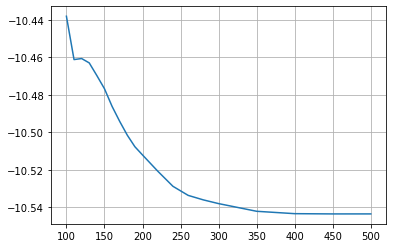

In [1]:
from numpy import *
import matplotlib.pyplot as plt

data = loadtxt('results/Q6_energy.txt')

plt.plot(data[:,0],data[:,1])
plt.grid()
plt.show()

# Question 7

number of bands: 16
number of k-points: 600
is metal: True
is spin polarized: False
Fermi energy: 9.49328909
band gap: {'energy': 0.0, 'direct': False, 'transition': None}


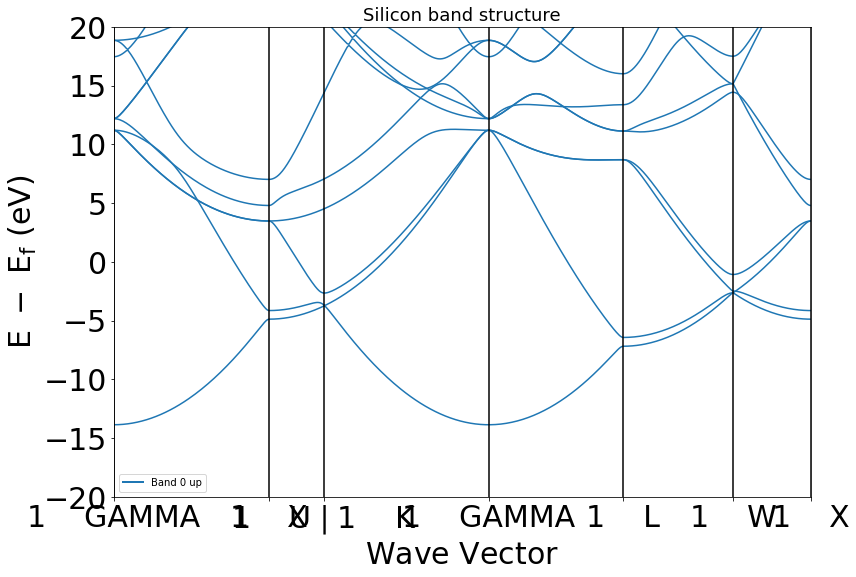

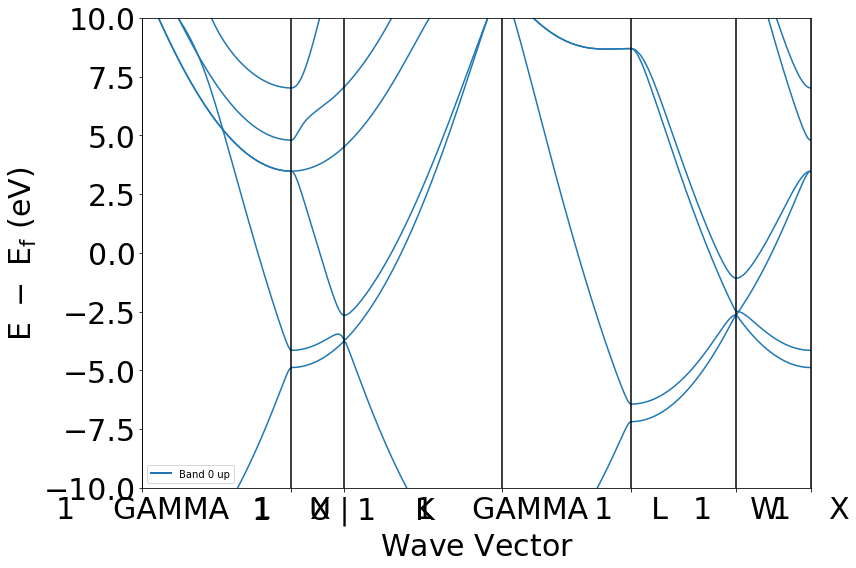

In [2]:
import pymatgen.core as mg
from pymatgen.io.vasp.outputs import BSVasprun, Vasprun
from pymatgen.electronic_structure.core import Spin
from pymatgen.electronic_structure.plotter import BSPlotter, BSDOSPlotter, DosPlotter

import matplotlib.pyplot as plt

def print_bands (bs):
	for kpoint, band in zip (bs.kpoints, bs.bands [Spin.up]):
		kx = kpoint.frac_coords [0]
		ky = kpoint.frac_coords [1]
		kz = kpoint.frac_coords [2]
		for energy in band:
			print ("k = [{:+.3f} {:+.3f} {:+.3f}]    E(k) = {:+.6e}".format (kx, ky, kz, energy))

run = BSVasprun ("results/Q7_vasprun.xml", parse_projected_eigen = True)
bs = run.get_band_structure ("results/Q7_KPOINTS")

print ("number of bands:", bs.nb_bands)
print ("number of k-points:", len (bs.kpoints))
print ("is metal:", bs.is_metal ())
print ("is spin polarized:", bs.is_spin_polarized)
print ("Fermi energy:", bs.efermi)

print ("band gap: {}".format (bs.get_band_gap ()))

bsplot = BSPlotter (bs)
bsplot.get_plot (ylim = (-20, 20), zero_to_efermi = True)
ax = plt.gca ()
ax.set_title ("Silicon band structure", fontsize = 18)

ax.plot (label = "spin up")
bsplot.show ()

# Question 8

Previously, we had:
```
FCC Silicon
 3.9
0.5 0.5 0.0
0.0 0.5 0.5
0.5 0.0 0.5
  1
cartesian
  0 0 0
```
Now, we have 
```
Real silicon (diamond-like)
 5.5
0.0 0.5 0.5
0.5 0.0 0.5
0.5 0.5 0.0
  2
Direct
  -0.125 -0.125 -0.125
  +0.125 +0.125 +0.125
```
The lattice constant has increased and the lattice vectors changed

# Question 9

What changed :
```
SYSTEM = FCC Silicon
ISTART = 0
ICHARG = 2
LREAL = .FALSE.
```
becomes:
```
SYSTEM = Real silicon (diamond-like)
IBRION = 2
ISIF = 3
NSW = 20
EDIFFG = -1e-4
```
`IBRION` parameter set to 2 allow to use the conjugate gradient algorithm\
`ISIF` allow to compute the forces and the stress tensor for cells with all the possible degree of liberty (positions, cell shape and cell volume)